# Michelson response to GW signal and noise

In this notebook we want to model transfer functions and noises in an interferometer so that we can generate our first sensitivity plot.

**After this notebook you will be able to**:

* compute the Michelson interferometer response to gravitational wave signal
* compute the frequency-noise limited sensitivity of a Michelson interferometer
* compute the quantum-noise limited sensitivity of a Michelson interferometer
* read and explain a sensitivity curve
* explain the concept of a noise budget

## Getting Started

As usual, begin by loading PyKat and the other Python packages we will need. This time, we also define some simple functions do describe different kinds of noise, which you will use below. 


(type shift+enter to run)

In [1]:
from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting
from matplotlib.ticker import FormatStrFormatter

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90,fmts=['png'])

#Noise ASD functions used in later tasks.
#The noise sources are fake, but roughly based on the types of noises we actually see in the detectors
def frequency_noise_ASD(f):
    # for task 5.
    # As an aside, this kind of 1/f noise is characteristic
    # of the type of lasers used in LIGO, known as 
    # NPROs (Non-Planar ring oscillator)
    f = np.array(f)
    return 1e4/abs(np.random.normal(f, f/10, size=f.size))
def seismic_noise_ASD(f):
    #for extension task 1
    f = np.array(f)
    N = 1e-1/abs(np.random.normal(f**15, f/2, size=f.size))
    N += 1e-28
    return N

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## Planning the Model

Let us remember the key questions when planning a simulation task:

 - what is the question your model is trying to answer? (and is Finesse the right tool to answer it?)
 - what plot/number will tell you that answer?
 - what parts of your experiment do you need to include for the result to be meaningful?

**Today's model**

Today, we will model a simple Michelson interferometer that could be used to detect gravitational waves.

We will:
1. Construct a plane waves model of the Michelson, plotting the power transmitted, reflected, and circulating from the cavity as its length is changed. 
1. Compute transfer functions of some important noise sources to the GW detection channel.
1. Construct a noise budget and identify the limiting noise sources.

## How to model a transfer function 
Transfer functions show us how signals propagate through system.

To model a transfer function in Finesse there is a specfic recipe you must follow:

1. Add an `fsig` command. e.g. `fsig sig1 laser amp 1 0 1`, this adds a signal to the simulation called `sig1`, it takes the `laser` and modulates the `amp` (amplitude). It does this at `1`Hz, with `0` phase offset, with an amplitude of `1`.
1. Add a detector to demodulate this signal, e.g. `pd1 tf $fs n1`. This measures the signal we added with the `fsig` command before. `$fs` is a special variable which is always the same frequency as the `fsig` command.
1. Scan the signal frequency we are applying, e.g. `xaxis sig1 f log 10k 1G 1000`. To generate a transfer function we have to calculate how the modulation responds at a range of frequencies. This `xaxis` command changes the frequency which we modulate the amplitude.
1. Use `yaxis abs:deg` to get the complex valued transfer function, so we can see amplitude and phase.

#### Example: power oscillations $\to$ photodiode output
In this example we compute how laser power (intensity) noise affects a photodiode output. We create the power oscillations by modulating the `laser`'s amplitude using the special command `fsig`. This will modulate the amplitude at particular frequency. We then measure how this modulation propagates to a photodiode output by demodulating a photodiode output at the same frequency as the oscillation. This process calculates the transfer function.

The pykat code for this is:

```python
kat = finesse.kat()          # Initialising Finesse
kat.verbose = False          # Tells Finesse to talk less

code = '''
l laser 2 0 n0            # Laser with 0 offset wavelength (thus default 1064nm used)
s s1 1 n0 n1              # Space from laser to mirror (1 m)
fsig sig1 laser amp 1 0 1 # Laser power fluctuations (freq 1 Hz, phase 0, amplitude 1)

# Demodulate our signal to compute a transfer function
# The $fs variable is a special one in Finesse, its value is always the current signal frequency
pd1 tf $fs n1 

# Sweep the frequency of the signal applied from 10kHz to 1GHz in 1000 steps
xaxis sig1 f log 10k 1G 1000
yaxis abs:deg
'''
kat.parse(code)                                  # passing the input text to the Finesse object
out = kat.run()

fig = out.plot(title='Bode diagram',
               ylabel='$|H(\omega)|$ $[\mathrm{W}/\sqrt{\mathrm{W}}]$',
               detectors=["tf"])
```

which results is the plot:
<img src="https://www.dropbox.com/s/qidore36owllcln/FinesseTFeg.png?raw=1" width=40% height=40%>

This plot shows the magnitude and phase of the transfer function. The units of the transfer function are always Watts per `X`, where `X` is the units of thing we are modulating. In this example we are modulating the amplitude, so `X` = $\sqrt{W}$. You may find the default units Finesse returns various transfer functions in by referring to the [Finesse manual](https://www.gwoptics.org/finesse/download/manual.pdf).

#### Multiple fsigs

In Finesse you can use multiple `fsig` commands at once in a simulation. *However, the signal frequency will be the **same** for all the signals in a single simulation*. This is useful when you have two effects happening at once. For example, two mirrors are being moved at the same time but out of phase with each other, as one moves in one direction, the other mirror moves in the opposite direction. This signal can be described with the following two `fsig` commands:
```python
fsig sig1 MX z 1 0 1
fsig sig2 MY z 1 180 1
```
Here we shake the `MX` and `MY` mirrors but out of phase by 180 degrees.

#### Options for fsig

The below table is a handy list of parameters that can be modulated with an `fsig` command. You might find it helpful in the proceeding tasks.


<table>
    <th>
        <td>**Component**</td>
        <td>**Target**</td>
        <td>**Unit**</td>
        <td>**Description**</td>
    <th/>
    <tr>
        <td></td>
        <td>Mirror/Beamsplitter</td>
        <td>`phase`</td>
        <td>`W/deg`</td>
        <td>Mirror tuning modulation</td>
    </tr>
    <tr>
        <td></td>
        <td>Mirror/Beamsplitter</td>
        <td>`z`</td>
        <td>`W/m`</td>
        <td>Mirror tuning modulation</td>
    </tr>
    <tr>
        <td></td>
        <td>Laser</td>
        <td>`freq`</td>
        <td>`W/Hz`</td>
        <td>Modulates laser frequency</td>
    </tr>
    <tr>
        <td></td>
        <td>Laser</td>
        <td>`phase`</td>
        <td>`W/deg`</td>
        <td>Modulates laser phase</td>
    </tr>
    <tr>
        <td></td>
        <td>Laser</td>
        <td>`amp`</td>
        <td>`W/sqrt{W}`</td>
        <td>Modulates laser amplitude</td>
    </tr>
    <tr>
        <td></td>
        <td>Space</td>
        <td>`phase`</td>
        <td>`W/h`</td>
        <td>Modulates the optical phase for a<br/>gravitational wave strain of `h`</td>
    </tr>
</table>


## The Optical Layout

Here we provide the Finesse code for a Michelson, use this for all the tasks below. It is based on this image:

<img src="http://www.gwoptics.org/learn/schools/Beijing_2017/michelson01.svg" width=40%/>

You should look at the commands that have been used and understand how the components are connected together. Remember that Finesse has the option to visualize the nodal connections using the [node-graph](https://ifosim.sr.bham.ac.uk/iucaa2019/2019/12/19/generating-node-graphs-from-finesse-scripts/) functionality.

```python
#---------------------------------------------------------------------------
# The core optical layout, without any detectors or simulation instructions.
#---------------------------------------------------------------------------

base = finesse.kat()          # Initialising Finesse
base.verbose = False          # Tells Finesse to talk less

base.parse( """
l laser 1M 0 n0                        # Laser (P=1MW, 0 wavelength offset from 1064nm)           
s s0 1 n0 nBSb                         # Space from laser to beam splitter (1 m)

## Central beam splitter ##
bs BS 0.5 0.5 0 45 nBSb nBSy nBSx nBSd # Central beam splitter (0.5 refl, 0.5 trans, 0 deg. tuning,
                                       #                        45 degrees angle of incidence)                                                               
## X arm ##
s LX 4000 nBSx nMX1                    # Space: Length of X arm 
m MX 1 0 -45.003 nMX1 nMX2             # Mirror MX (R=1, T=0, -45deg tuning)

## Y arm ##
s LY 4000.01 nBSy nMY1                 # Space: Length of Y arm 
m MY 1 0 45.003 nMY1 nMY2              # Mirror MY (R=1, T=0, +45deg tuning)

## Output ##
s sout 1 nBSd nout                     # Space from BS to the photodiode (1 m)
""")            
```

**A Sidenote on these model parameters (not needed to complete the tasks):**

LIGO's design uses a 125 W input laser, which is one of the most powerful lasers made. The Michelson model uses a laser that has an output power of 1MW! This is very high and also slightly unrealisitic: LIGO instead uses additional optical cavities to make a 125W laser into several kW of circulating power in the arm cavities. 

You should note that this time the end mirrors, `MX` and `MY`, have a differential tuning of $\pm 45.003$ to set the operating point of our Michelson to be almost at the dark fringe, so very little light is leaving the output port. The output port in this model is at the node `nout`. This is where we will add detectors to measure the optical fields to readout gravitational wave signals and noise.

You should also see that the X and Y arm lengths are not exactly the same. This is a design decision that is too complicated to describe now. For all your models, the Y-arm should be 1cm longer than the X-arm.

<div style="background-color:#cceffc;padding:10px;">

### Task 1: The gravitational wave signal

The gravitational wave will modulate the phase of the light travelling along a space. We can apply this type of signal to a space component in Finesse using: `fsig sig1 space phase 1 0 1`.

1. Using the code for the Michelson model given above:
    - Add two `fsig sig1 space_name phase 1 0 1` commands to modulate the X-arm and Y-arm space at the same time, one of the `fsig`s phase should be 180 degrees different to the other, as the gravitational wave will make one arm bigger whilst the other gets smaller (assuming GR is correct).
    - Add in a photodiode to measure the transfer function at the Michelsons output port.
    - Scan the signal from 1Hz to 100kHz in 1000 steps logarithmically.
    - Plot the magnitude and phase of this transfer function in a Bode plot.

The units of this transfer function will be $W/h$ where $h$ is the gravitational wave strain. The strain value will typically be something very small, $h \sim 10^{-23}$.


2. Are the detectors more susceptible to low or high frequency gravitational waves? Why is this so?


3. The magnitude of the transfer function goes to 0 at some frequencies, why is this?

</div>

In [2]:
### Start the base model with the code above

          

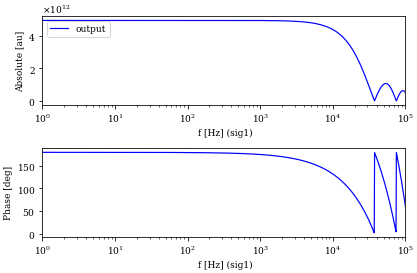

In [4]:
kat = base.deepcopy()
kat.parse("""

""")
MichTF = kat.run() 
MichTF.plot(ylabel='',title='GW signal TF') #what are the units for this transfer function?

<div style="background-color:#cceffc;padding:10px;">

### Task 2: Frequency noise response

In this task we will compute how laser frequency noise couples to the Michelson output.

Using the Michelson model from Task 1:
- Add one `fsig` command to modulate the frequency of the input laser. Use the reference table above to get the correct command.
- Add in the photodiode to measure a transfer function to the Michelson output port.
- Scan the signal from 1Hz to 100kHz in 100 steps logarithmically.
- Plot the magnitude and phase of this transfer function in a Bode plot.

</div>

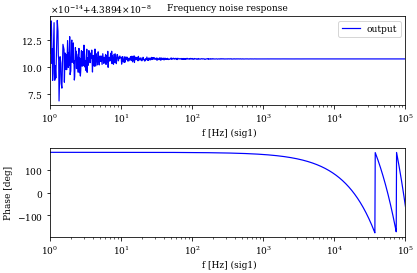

In [14]:
kat = base.deepcopy()
kat.parse("""

""")

MichFresp = kat.run()
MichFresp.plot(ylabel='',title='Frequency noise response')

## Frequency noise limited sensitivity

In this task we will produce our first sensitivity plot. This will show how the laser frequency noise transfers to the output port where we measure for a gravitational wave, and then limits our sensitivity to measure GWs.

To compute the frequency noise limited sensitivity you must calculate:

\begin{equation}S_f(f) = \frac{N_f(f) |H_n(f)|}{|H_s(f)|}\end{equation}

$N_f$ is the amplitude spectral density of the frequency noise of the laser (which we defined using some assumed model earlier in this notebook), $H_n$ is the transfer function from laser frequency to the output port, and $H_s$ is the transfer function of the signal to the output port. The unit of this quantity works out as:

\begin{equation}\frac{[Hz/\sqrt{Hz}] [W/Hz]}{[W/h]} = \frac{h}{\sqrt{Hz}}\end{equation}

Which is the _equivalent strain amplitude spectral density from frequency noise_. In LIGO-parlance, this is sometimes referred to as *signal-referred sensitivity*.

We will generate some frequency noise that would come out of a laser that we have just bought using the function defined above. Use it to generate $N_f(f)$ using the code:

```python
f = out.x # you should use the same frequency values that Finesse
          # outputs on the xaxis when you scan the frequency.
N_f_asd = frequency_noise_ASD(f)
```

<div style="background-color:#cceffc;padding:10px;">
    
### Task 3: Frequency noise limited sensitivity
Use your results from tasks 1 and 2 for the transfer functions, calculate a fake $N_f$ as shown above, and then calculate $S_f(f)$ from above. Plot $S_f(f)$ from 1Hz to 100kHz.
</div>

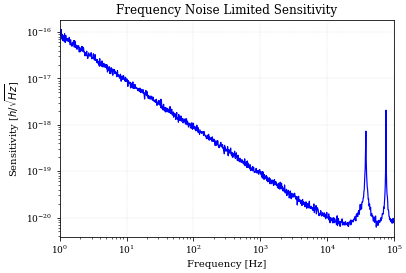

In [6]:
#define a function for the sensitivity plot for frequency noise (Equation S_f above, python command is "def name(inputs):"


#generate the frequency noise spectrum


#Calculate the frequency noise limited sensitivity (using Hn, Hs, and Nf)


# Plot
plt.loglog(f, S_f)

#Plot properties
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]")
plt.title('Frequency Noise Limited Sensitivity');

## Mirror motion to output port transfer function - seismic noise

In this task we will model how the motion of a mirror appears in the output detector. This is an important transfer function, as many sources of noise will shake the mirrors individually. For example, seismic noise from the Earth will shake the mirrors in the detectors. However, this shaking is **not coherent** between all the mirrors because the mirrors are so far away from each other (if one wanted to be rigorous, one could measure the correlation as a function of frequency, but for the frequencies of interest to GW detectors, this assumption is valid). 

\begin{equation}S_s(f) = \frac{N_s(f) |H_m(f)|}{|H_s(f)|}\end{equation}

where $S_s(f)$ is the _equivalent strain amplitude spectral density from seismic noise_, $N_s(f)$ is the motion in meters of the mirror due to seismic noise (we defined a function for this earlier also), $H_m(f)$ is the transfer function from the mirror to the output detector, and $H_s(f)$ is the transfer function of the gravitational wave signal.

You can get the seismic noise using this function:
```python
f = out.x # you should use the same frequency values that Finesse
          # outputs on the xaxis when you scan the frequency.
N_s_asd = seismic_noise_ASD(f)
```
<div style="background-color:#cceffc;padding:10px;">
    
### Task 4: Seismic Noise Limited Sensitivity

For the Michelson Interferometer model 

1. Use the table above to find the `fsig` command to modulate the mirror position in units of [W/m].

2. The seimic noise will shake the two end mirrors separately (you will need two simulations.) Compute and plot the transfer function in units of [W/m] for the:
    - `MX` mirror to the output port
    - `MY` mirror to the output port

3. Compute and plot the _equivalent strain amplitude spectral density from seismic noise_. For this you will need to sum the seismic noise from the `MX` and `MY` mirror (in quadrature).
</div>

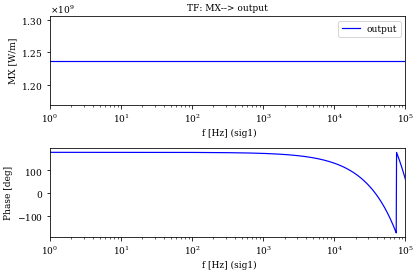

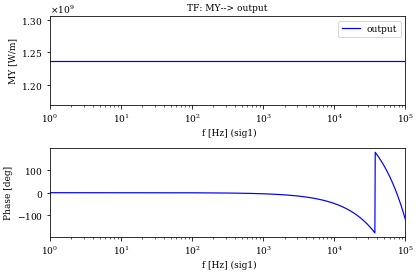

In [7]:
#MX mirror TF
kat = base.deepcopy()
kat.parse("""

""")

out = kat.run()
Hmx = abs(out['output']) # Here we save the transfer function to use later too
fig = out.plot(ylabel="MX [W/m]", title='TF: MX--> output')

#MY mirror TF
kat = base.deepcopy()
kat.parse("""

""")

out = kat.run()
Hmy = abs(out['output']) # Here we save the transfer function to use later too
fig = out.plot(ylabel="MY [W/m]", title='TF: MY--> output')

Text(0, 0.5, 'Sensitivity [$h/\\sqrt{Hz}$]')

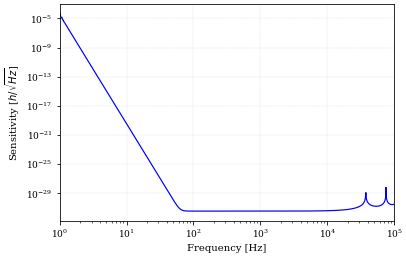

In [9]:
# sensitivity plot for seismic noise


# Here we compute the seismic noise limited sensitivity (Ss as defined above for each mirror, added in quadrature)
S_s = 

plt.figure()
plt.loglog(f, S_s)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]")

## Quantum Noise

"Quantum noise" is an umbrella term used to refer to multiple complicated effects in the interferometer. However, they are all a direct consequence of the photonic nature of the light field, their associated Poissonian statistics, and the Heisenberg uncertainty principle. The details are unimportant for our modeling tasks, but the interested reader may find this [review article](https://arxiv.org/abs/1203.1706) informative.


In Finesse the `qnoised` detector can be used to directly compute the quantum noise amplitude spectral density at the output port of an interferometer.


The output of `qn` has the form $N_q(f) |H_p(f)|$, where $N_q$ is the amplitude spectral density of the quantum noise and $H_p$ the transfer function from quantum noise to the output port, so 
we can then directly combine this output with the transfer function computed in task 1 to get the *Quantum Noise Limited Sensitivity* of the interferometer:
\begin{equation}S_q(f) = \frac{\mathtt{out[`qn`]}}{|H_s(f)|}\end{equation}

The finesse syntax you will need is
```
fsig noise 1
qnoised qn 1 $fs nout
xaxis noise f log 1 100k 1000
```

where the `xaxis` range should be the same as you have used in each of the previous tasks.

<div style="background-color:#cceffc;padding:10px;">
    
### Task 5: The Noise Budget

Now we are ready to make a noise budget for our Michelson! We will add the seismic noise, frequency noise, and finally the quantum noise and compute the total sensitivity. Remember that these are not all the noise sources! This is just generating an example plot for you to experiment with.

1. Use `fsig` and `qnoised` commands to compute the quantum noise limited sensitivity and plot the result. 


2.  plot on the same graph:
    - The quantum noise limited sensitivity
    - The frequency noise limited sensitivity
    - The seismic noise limited sensitivity
    - The sum of these three noises to get the total sensitivity

**Tip 1:** Remember, when adding noise sources $A$, $B$, and $C$ together, $\sqrt{A^2 + B^2 + C^2}$.

**Tip 2:** When plotting this curve it might be useful to limit the y-axis using the function `plt.ylim(lower, upper)`. For example, `plt.ylim(1e-24, 1e-18)` to limit the sensitivity between 1e-24 and 1e-18.


2. The frequency noise should be much larger than quantum and seismic noise, it is the dominant noise source. By what factor do you need to reduce the frequency noise by to measure a gravitational wave at 100Hz with a strength of $h\sim10^{-23}$? This is one of the principal challenges of the LIGO experiment.


3. Make the same plot sensitivity plot as you did in step (1) but this time reduce the frequency noise by the factor you computed in step (2). What are the limiting noise sources in various frequency bands now?

</div>

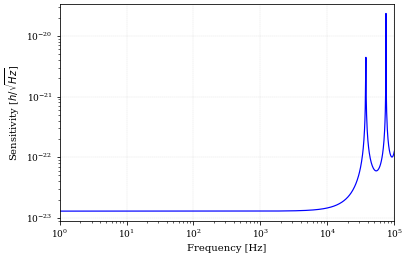

In [10]:
#quantum noise limited sensitivity alone:

kat = base.deepcopy()
kat.parse("""

""")

out = kat.run()
f = out.x   # Here is the frequency vector we will use for the sensitivity, any 'out.x' from the simulations above should work, provided you used the same number of points in each simulation

# The quantum noise limited strain sensitivity


plt.figure()
plt.loglog(f, S_q)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]");

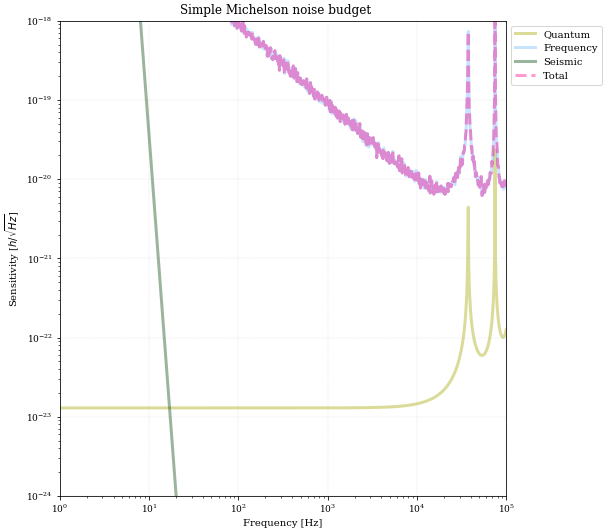

In [11]:
#all curves together (Plot Sq, Sf and Ss)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.loglog(f, S_q, label="Quantum", alpha=0.4, color='xkcd:puke', linewidth=3)
ax.loglog(f, S_f, label="Frequency", alpha=0.4, color='xkcd:sky blue', linewidth=3)
ax.loglog(f, S_s, label="Seismic",alpha=0.4, color='xkcd:forest green', linewidth=3)

#Calculate the total noise. Noise sources add in quadrature!

ax.loglog(f, total, label="Total", alpha=0.4, color='xkcd:electric pink', linewidth=3, linestyle='--')

ax.set_ylim(1e-24, 1e-18)
ax.legend(loc=2,bbox_to_anchor=(1,1))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Sensitivity [$h/\sqrt{Hz}$]")
fig.suptitle('Simple Michelson noise budget');
fig.subplots_adjust(top=0.95)
#plt.margins(0, 0)

#laser frequency noise currently limits the sensitivity of the interferometer

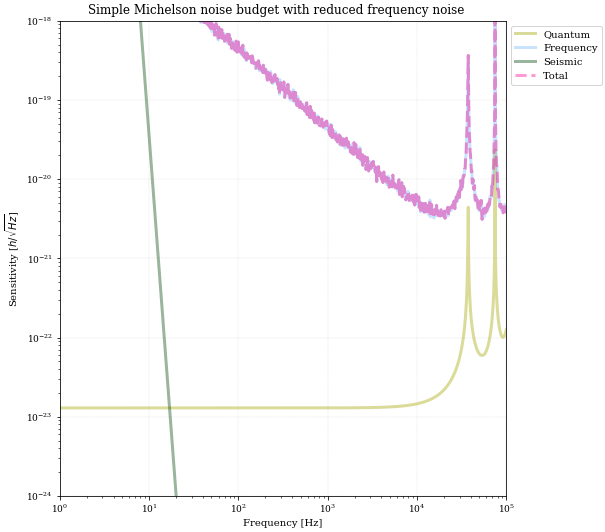